In [23]:
import os, sys

import numpy as np
import imageio
import pprint

import matplotlib.pyplot as plt

import run_nerf
import run_nerf_helpers

import torch

torch.set_grad_enabled(False)


### Load trained network weights
Run `bash download_example_weights.sh` in the root directory if you need to download the Lego example weights

Args:
expname = antler
basedir = ./logs
datadir = ./data/nerf_synthetic/antler
dataset_type = blender

no_batching = True

use_viewdirs = True
white_bkgd = False
lrate_decay = 500

N_samples = 64
N_importance = 128
N_rand = 1024

precrop_iters = 500
precrop_frac = 0.5

half_res = True


Found ckpts ['./logs/antler/200000.tar']
Reloading from ./logs/antler/200000.tar
Not ndc!
Render kwargs:
{'N_importance': 128,
 'N_samples': 64,
 'far': 6.0,
 'lindisp': False,
 'ndc': False,
 'near': 2.0,
 'network_fine': NeRF(
  (pts_linears): ModuleList(
    (0): Linear(in_features=63, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Linear(in_features=319, out_features=256, bias=True)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): Linear(in_fe

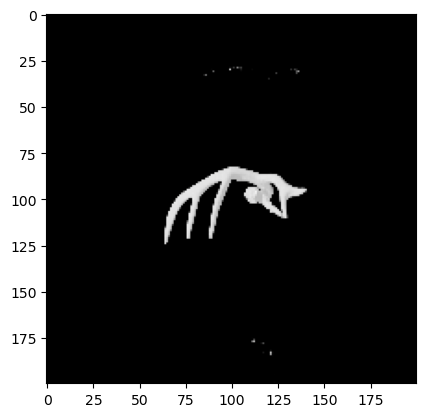

In [24]:

basedir = './logs'
expname = 'antler'

config = os.path.join(basedir, expname, 'config.txt')
print('Args:')
print(open(config, 'r').read())

parser = run_nerf.config_parser()
ft_str = '' 
ft_str = '--ft_path {}'.format(os.path.join(basedir, expname, '200000.tar'))
args = parser.parse_args('--config {} '.format(config) + ft_str)

# Create nerf model
_, render_kwargs_test, start, grad_vars, models = run_nerf.create_nerf(args)

bds_dict = {
    'near' : 2.,
    'far' : 6.,
}
render_kwargs_test.update(bds_dict)

print('Render kwargs:')
pprint.pprint(render_kwargs_test)

net_fn = render_kwargs_test['network_query_fn']
print(net_fn)

# Render an overhead view to check model was loaded correctly
c2w = np.array([[
                -4.371138828673793e-08,
                -0.4999999701976776,
                0.866025447845459,
                3.464101552963257
            ],
            [
                1.0,
                -5.346582909737663e-08,
                1.9605055356919365e-08,
                0.0
            ],
            [
                3.650023927548318e-08,
                0.866025447845459,
                0.4999999701976776,
                2.0
            ],
            [
                0.0,
                0.0,
                0.0,
                1.0
            ]
])
c2w = torch.from_numpy(c2w)
H, W, focal = 800, 800, 1200.
down = 4
H //=down
W //=down
focal /=down
K = np.array([
    [focal, 0, 0.5*W],
    [0, focal, 0.5*H],
    [0, 0, 1]
])
test = run_nerf.render(H, W, K, c2w=c2w, **render_kwargs_test)
img = np.clip(test[0],0,1)
plt.imshow(img)
plt.show()

### Query network on dense 3d grid of points

(257, 257, 257, 3)
(257, 257, 257, 4)
(257, 257, 257)


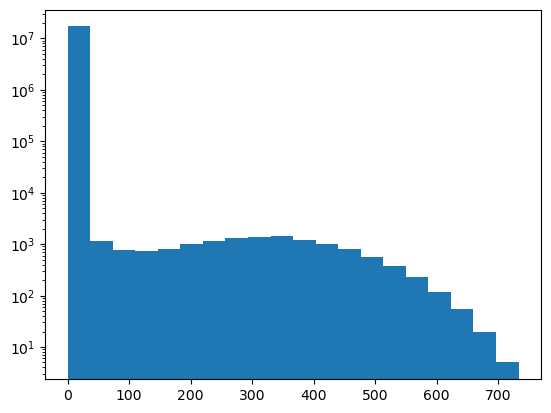

In [25]:
N = 256
t = np.linspace(-1.2, 1.2, N+1)

query_pts = np.stack(np.meshgrid(t, t, t), -1).astype(np.float32)
print(query_pts.shape)
sh = query_pts.shape
flat = torch.from_numpy(query_pts.reshape([-1,3]))


def batchify(fn, chunk):
    if chunk is None:
        return fn
    def ret(inputs):
        return torch.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    return ret
    
    
fn = lambda i0, i1 : net_fn(flat[i0:i1,None,:], viewdirs=torch.zeros_like(flat[i0:i1]), network_fn=render_kwargs_test['network_fine'])
chunk = 1024*64
raw = np.concatenate([fn(i, i+chunk).numpy() for i in range(0, flat.shape[0], chunk)], 0)
raw = np.reshape(raw, list(sh[:-1]) + [-1])
sigma = np.maximum(raw[...,-1], 0.)

print(raw.shape)
print(sigma.shape)
plt.hist(np.maximum(0,sigma.ravel()), log=True,bins=20)
plt.show()

### Marching cubes with [PyMCubes](https://github.com/pmneila/PyMCubes)
Change `threshold` to use a different sigma threshold for the isosurface

In [49]:
import mcubes

threshold = 50.
print('fraction occupied', np.mean(sigma > threshold))
vertices, triangles = mcubes.marching_cubes(sigma, threshold)
print('done', vertices.shape, triangles.shape)

### Uncomment to save out the mesh
mcubes.export_mesh(vertices, triangles, "logs/{}/{}_{}.dae".format(expname, expname, N), expname)

fraction occupied 0.0007983696575228637
done (12740, 3) (25352, 3)


### Live preview with [trimesh](https://github.com/mikedh/trimesh)
Click and drag to change viewpoint

In [50]:
import trimesh

mesh = trimesh.Trimesh(vertices / N - .5, triangles)
mesh.show()

# Skeleton Extraction

In [84]:
import skeletor as sk
mesh_ex = sk.example_mesh()
# To load and use your own mesh instead of the example mesh:
# import trimesh as tm
fixed = sk.pre.fix_mesh(mesh, remove_disconnected=100, inplace=False)
skel = sk.skeletonize.by_wavefront(fixed, waves=1, step_size=1)
print(skel)
fixed.show()
sk.post.clean_up(skel, inplace=True)
# skel.save_swc("example.swc")
# skel.save_swc("logs/{}/{}_{}.swc".format(expname, expname, N))

Skeletonizing:   0%|          | 0/12392 [00:00<?, ?it/s]

<Skeleton(vertices=(351, 3), edges=(350, 2), method=wavefront)>


<Skeleton(vertices=(350, 3), edges=(349, 2), method=wavefront)>

In [85]:
from trimesh.path import Path3D, entities

# Create all edges as line entities
line_entities = []
for i, edge in enumerate(skel.edges):
    line_entities.append(entities.Line([edge[0], edge[1]]))

# Create Path3D object
skeleton_path = Path3D(
    vertices=skel.vertices,
    entities=line_entities,
    colors=np.tile([255, 0, 0, 255], (len(skel.edges), 1))  # Red RGBA
)

# Add to scene and show
scene = trimesh.Scene()
scene.add_geometry(skeleton_path)
scene.show()

### Save out video with [pyrender](https://github.com/mmatl/pyrender)

In [29]:
# os.environ["PYOPENGL_PLATFORM"] = "egl"
# import pyrender
# from load_blender import pose_spherical

In [30]:
# scene = pyrender.Scene()
# scene.add(pyrender.Mesh.from_trimesh(mesh, smooth=False))

# # Set up the camera -- z-axis away from the scene, x-axis right, y-axis up
# camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)

# camera_pose = pose_spherical(-20., -40., 1.).numpy()
# nc = pyrender.Node(camera=camera, matrix=camera_pose)
# scene.add_node(nc)

# # Set up the light -- a point light in the same spot as the camera
# light = pyrender.PointLight(color=np.ones(3), intensity=4.0)
# nl = pyrender.Node(light=light, matrix=camera_pose)
# scene.add_node(nl)

# # Render the scene
# r = pyrender.OffscreenRenderer(640, 480)
# color, depth = r.render(scene)

# plt.imshow(color)
# plt.show()
# plt.imshow(depth)
# plt.show()


In [31]:
# imgs = []
# for th in np.linspace(0, 360., 120+1)[:-1]:
#     camera_pose = pose_spherical(th, -40., 1.).numpy()
#     scene.set_pose(nc, pose=camera_pose)
#     imgs.append(r.render(scene)[0])
# f = 'logs/lego_example/lego_mesh_turntable.mp4'
# imageio.mimwrite(f, imgs, fps=30)
# print('done')

In [32]:
# from IPython.display import HTML
# from base64 import b64encode
# mp4 = open(f,'rb').read()
# data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
# HTML("""
# <video width=400 controls autoplay loop>
#       <source src="%s" type="video/mp4">
# </video>
# """ % data_url)